In [1]:
import gym
import random
import tensorflow as tf
from tensorflow import keras
import numpy as np
from collections import deque
from keras.optimizers import RMSprop



%matplotlib inline
import matplotlib.pyplot as plt


from keras import models
from keras import layers

In [2]:

# env = gym.make("CartPole-v0")

# def randomgames():
    
#     for i in range(1):
#         state = env.reset()
        
#         for t in range(500):
            
#             env.render()
#             action = env.action_space.sample()
            
#             new_state, reward, done, info = env.step(action)
            
            
#             print(t, new_state, reward, done, info)
            
#             if done:
#                 break
#     env.close()
                
# randomgames()


In [3]:
def NNmodel(input_shape, action_space):
    
    X_input = layers.Input(input_shape)
    X = layers.Dense(512, input_shape = input_shape, activation = "relu", kernel_initializer = 'he_uniform')(X_input)
    X = layers.Dense(256, activation = "relu", kernel_initializer = 'he_uniform')(X)
    X = layers.Dense(64, activation = "relu", kernel_initializer = 'he_uniform')(X)
    X_output = layers.Dense(action_space, activation = "linear", kernel_initializer = 'he_uniform')(X)
    
    model = models.Model(inputs = X_input, outputs = X_output, name='CartPole_DQN_model')   #Change
    
    model.compile(loss = "mse", optimizer = RMSprop(lr = 0.00025, rho = 0.95, epsilon = 0.01), metrics = ["accuracy"])
    
    model.summary()
    
    return model

In [9]:
class DQNAgent:
    
    def __init__(self):
        
        self.env = gym.make('CartPole-v1')
        # by default, CartPole-v1 has max episode steps = 500
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.EPISODES = 1000
        self.testEPISODES = 100
        self.memory = deque(maxlen=2000)
        
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.999
        self.batch_size = 64
        self.train_start = 1000
        
        # For stats
        self.ep_rewards = []
        self.aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}
        self.STATS_EVERY = 50

        

        # create main model
        #self.model = NNmodel(input_shape = self.state_size, action_space = self.action_size)    #Why doesn't this work?
        self.model = NNmodel(input_shape=(self.state_size,), action_space = self.action_size)
        
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:                
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    
    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))
        

    def replay(self):
        if len(self.memory) < self.train_start:
            return
        # Randomly sample minibatch from the memory
        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # do batch prediction to save speed
        target = self.model.predict(state)
        target_next = self.model.predict(next_state)

        for i in range(self.batch_size):
            # correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                # Standard - DQN
                # DQN chooses the max Q value among next actions
                # selection and evaluation of action is on the target Q Network
                # Q_max = max_a' Q_target(s', a')
                target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))

        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)
        

        

    def load(self, name):
        self.model = models.load_model(name)

    def save(self, name):
        self.model.save(name)
            
    def run(self):        
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            
            episode_reward = 0
            
            while not done:
                #self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                
                episode_reward += reward     #Without penalty for failure
                
                if not done or i == self.env._max_episode_steps-1:     #Hmmm messing with the environment rewards is allowed?
                    reward = reward
                else:
                    reward = -100
                    
                #episode_reward += reward    #With penalty for failure
                    
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                if done:                   
                    print("episode: {}/{}, score: {}, e: {:.2}".format(e, self.EPISODES, i, self.epsilon))
                    if i == 500:
                        print("Saving trained model as cartpole-dqn.h5")
                        self.save("cartpole-dqn.h5")
                        return
                self.replay()
                
                
            self.ep_rewards.append(episode_reward)
            
            if not e % self.STATS_EVERY:
                average_reward = sum(self.ep_rewards[-self.STATS_EVERY:])/self.STATS_EVERY
                self.aggr_ep_rewards['ep'].append(e)
                self.aggr_ep_rewards['avg'].append(average_reward)
                self.aggr_ep_rewards['max'].append(max(self.ep_rewards[-self.STATS_EVERY:]))
                self.aggr_ep_rewards['min'].append(min(self.ep_rewards[-self.STATS_EVERY:]))
                print(f'Episode: {e:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {self.epsilon:>1.2f}')  
                
  
    def test(self):
        self.load("cartpole-dqn.h5")
        for e in range(self.testEPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                #self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)
                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e+1, self.testEPISODES, i))
                    break
                    
    def performance(self):
        plt.plot(self.aggr_ep_rewards['ep'], self.aggr_ep_rewards['avg'], label="average rewards")
        plt.plot(self.aggr_ep_rewards['ep'], self.aggr_ep_rewards['max'], label="max rewards")
        plt.plot(self.aggr_ep_rewards['ep'], self.aggr_ep_rewards['min'], label="min rewards")
        plt.legend(loc=4)
        plt.show()
        


Model: "CartPole_DQN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               2560      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 150,466
Trainable params: 150,466
Non-trainable params: 0
_________________________________________________________________
episode: 0/1000, score: 39, e: 1.0
Episode:     0, average reward:  0.8, current epsilon: 1.00
episode: 1/10

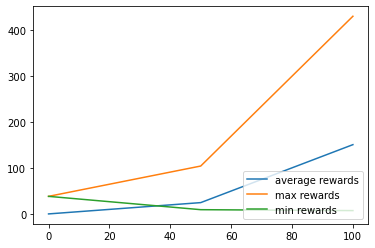

In [7]:
agent = DQNAgent()
agent.run()
agent.performance()

In [10]:
agent.test()

episode: 0/100, score: 500
episode: 1/100, score: 500
episode: 2/100, score: 500
episode: 3/100, score: 500
episode: 4/100, score: 500
episode: 5/100, score: 500
episode: 6/100, score: 500
episode: 7/100, score: 500
episode: 8/100, score: 500
episode: 9/100, score: 500
episode: 10/100, score: 500
episode: 11/100, score: 500
episode: 12/100, score: 500
episode: 13/100, score: 500
episode: 14/100, score: 500
episode: 15/100, score: 500
episode: 16/100, score: 500
episode: 17/100, score: 500
episode: 18/100, score: 500
episode: 19/100, score: 500
episode: 20/100, score: 500
episode: 21/100, score: 500
episode: 22/100, score: 500
episode: 23/100, score: 500
episode: 24/100, score: 500
episode: 25/100, score: 500
episode: 26/100, score: 500
episode: 27/100, score: 500
episode: 28/100, score: 500
episode: 29/100, score: 500
episode: 30/100, score: 500
episode: 31/100, score: 500
episode: 32/100, score: 500
episode: 33/100, score: 500
episode: 34/100, score: 500
episode: 35/100, score: 500
ep